In [1]:
from env import get_db_url
import wrangle_zillow
import model

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from matplotlib import rcParams

alpha = 0.05
rcParams['figure.figsize'] = 16,8
sns.set(font_scale=1.5)


In [2]:
df = wrangle_zillow.wrangle_zillow()

Using cached data


In [3]:
df = wrangle_zillow.handle_missing_zillow_values(df)

Shape before handling missing values: (77380, 61)
For threshold based dropping: 
(52463, 61)  original shape
(52463, 59)  shape after dropping columns with prop required rows below theshold
(52463, 59)  shape after dropping rows with prop required columns below threshold
Shape after removing nulls: (50906, 53)


Remove outliers from bathrooms, bedrooms, square footage, lot size, and tax value. This uses the IQR approach. 3.0 picked in order to limit data removal to <10%

In [4]:
df = wrangle_zillow.remove_outliers(df, 3.0, ['bathroom', 'bedroom','square_feet','lot_size','tax_value'])

Number of observations removed: 4545


In [5]:
df.shape

(46361, 53)

In [6]:
df.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county'],
      dtype='o

### Ask at least 5 questions about the data. Target is logerror
- Is log error significantly different for properties in different counties?
    - ANOVA and/or T-test
    - If assumptions can't be met, Kruskal-Wallis H-test (non-parametric ANOVA)
- How does log error change with square footage?
    - Correlation test
- Holding bedroom count constant, how does number of bathrooms correlate with logerro?
    - Correlation test
- Do houses with garages have log errors above or below those without?
    - T-test
- Does number of garages correlate with higher log error?
    - Correlation test



### Split data

In [7]:
train, validate, test = wrangle_zillow.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [8]:
train.shape, validate.shape, test.shape

((25961, 53), (11127, 53), (9273, 53))

In [9]:
train, validate, test = model.add_features(train, validate, test)

In [10]:
# No values show any significant correlation with logerror right off the bat
train.corrwith(train.abs_logerror).sort_values(ascending=False)[2:].head(10)

age                     0.096562
has_old_heat            0.057519
taxdelinquencyyear      0.052777
is_la                   0.032553
regionidcounty          0.028588
tax_rate                0.026136
bed_bath_ratio          0.025916
land_dollar_per_sqft    0.014003
lot_size                0.013878
acres                   0.013878
dtype: float64

### Which categories have statistically significant absolute log errors greater than the overall mean?

In [11]:
overall_mean = train.abs_logerror.mean()
high_cols =[]
high_option = []
high_difference = []
option_means = []
option_sample_size=[]

print(f"Overall mean logerror: {overall_mean}")
for col in train.columns:
    if train[col].nunique()<10:
        for option in train[col].unique():
            if len(train[train[col]==option].abs_logerror)>2:
                t, p = stats.ttest_1samp(train[train[col]==option].abs_logerror, train.abs_logerror.mean())
                if p<alpha:
                    sample_mean = train[train[col]==option].abs_logerror.mean()
                    difference = sample_mean - overall_mean
                    sample_size = len(train[train[col]==option].logerror)
                    # print(f"For {col} - {option} the mean ({sample_mean:.4f}) differs significantly from overall mean by {difference:.4f}, sample size {len(train[train[col]==option].logerror)}")
                    
                    # Only saving those values with greater than average absolute log errors and decent sampel
                    if (difference>0) and (sample_size>100):
                        high_cols.append(col)
                        high_option.append(option)
                        high_difference.append(difference)
                        option_means.append(sample_mean)
                        option_sample_size.append(len(train[train[col]==option].logerror))

high_log_errors = pd.DataFrame(data = {'column':high_cols,
                                      'option': high_option,
                                      'mean_abs_log_error': option_means,
                                      'difference_from_overall': high_difference,
                                      'option_sample_size':option_sample_size})
                                      

Overall mean logerror: 0.06905191781502365


In [12]:
high_log_errors.sort_values(by='difference_from_overall', ascending=False).head(20)

,column,option,mean_abs_log_error,difference_from_overall,option_sample_size
10,taxdelinquencyflag,Y,0.113254,0.044203,1012
1,bedroom,1.0,0.111660,0.042608,274
5,fullbathcnt,4.0,0.089026,0.019974,1065
4,fullbathcnt,1.0,0.088138,0.019086,5584
0,bedroom,2.0,0.087692,0.018640,4495
20,tax_value_bin,cheap,0.085341,0.016289,6491
12,heatingorsystemdesc,Floor/Wall,0.084062,0.015010,6727
24,has_old_heat,True,0.084062,0.015010,6727
16,age_bin,old,0.081043,0.011991,12483
22,structure_value_bin,low,0.080881,0.011829,6491


### Based on t-test results the highest positive error differences were with:
- Those houses that were delinquent on taxes
- Lower (1-2) bedroom homes
- Fullbathcnts of 1 and 4
- Houses with cheaper tax values
- Houses with heating system - Floor/Wall
- Old Houses
- Low Structure Value
- Small houses
- High bed to bath houses
- Low land value
- No garage
- Few baths
- LA county

In [13]:
train["delinquent_years"] = (17-train.taxdelinquencyyear)

In [14]:
delin = train[train.delinquent_years<17]

In [15]:
delin.abs_logerror.corr(delin.delinquent_years)

0.162287746133376

### Looking for clusters in there:
- Old, Small, low tax value houses with outdated heating systems (age, square feet, tax value, heating system)
- Cheap structure and land valued homes (structure dollar per sqft, land dollar per sqft)
- High full bath counts and high bed to bath houses 
- Tax delinquent, smaller bathrooms counts (2 or less), cheaper tax values

## AGE, SIZE, TAX VALUE (and has old heat) Cluster

## Scale data first

In [16]:
train_scaled, validate_scaled, test_scaled = model.scale_data(train, validate, test, ['age','square_feet','tax_value','structure_dollar_per_sqft','land_dollar_per_sqft','fullbathcnt','bed_bath_ratio','bathroom'])

In [17]:
X = train_scaled[['age_scaled','square_feet_scaled','tax_value_scaled','has_old_heat']]

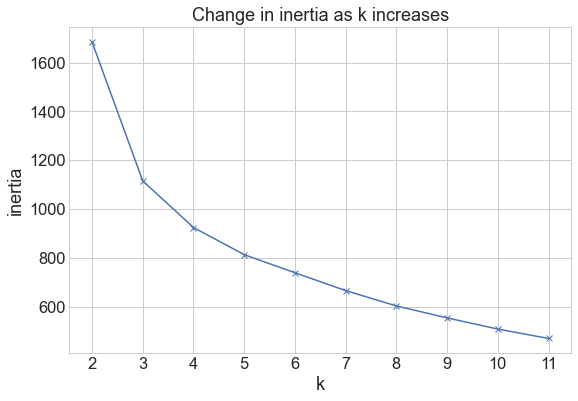

In [18]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### Choose k = 3, though it never really bends its arm

In [19]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(X)

train_scaled['age_size_value_cluster'] = kmeans.predict(X)
train_scaled.age_size_value_cluster = train_scaled.age_size_value_cluster.astype('category')

### See how the cluster did for finding abs log errors - does it differ significantly between cluster groups?

Text(0.5, 0, 'Cluster')

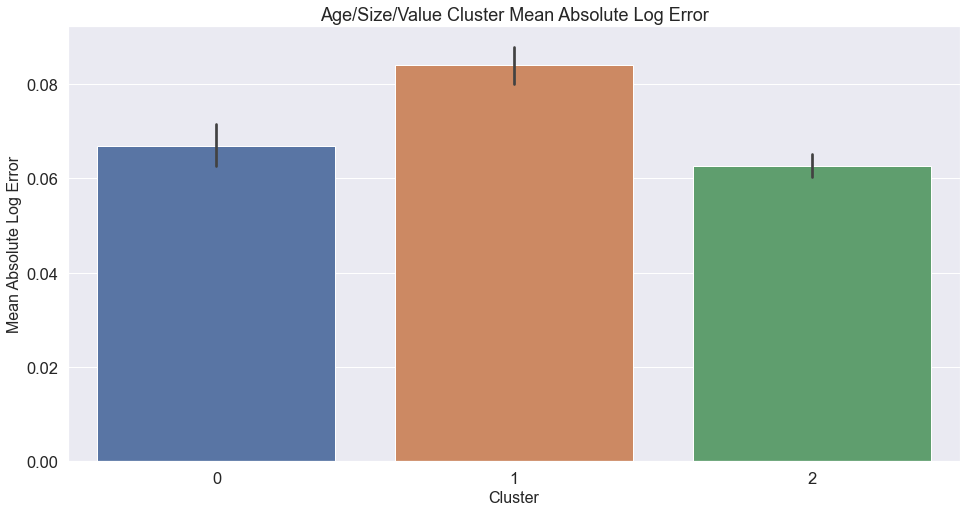

In [20]:
plt.figure(figsize=(16,8))
sns.barplot(data = train_scaled, x = 'age_size_value_cluster', y='abs_logerror')
plt.title("Age/Size/Value Cluster Mean Absolute Log Error")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("Cluster", fontsize=16)

In [21]:
overall_mean = train_scaled.abs_logerror.mean()
print(f"Overall mean logerror: {overall_mean}")
for col in set(train_scaled.age_size_value_cluster):
    sample = train_scaled[train_scaled.age_size_value_cluster==col]
    t, p = stats.ttest_1samp(sample.abs_logerror, overall_mean)
    print(col, "Significant? ", p<alpha, "t value: ", t)

Overall mean logerror: 0.06905191781502365
0 Significant?  False t value:  -0.9018448186871185
1 Significant?  True t value:  7.555036622329745
2 Significant?  True t value:  -5.3719238420206645


Cluster 1 shows significant above average absolute log error

Text(0.5, 1.0, 'Cluster 0 is old and small, Cluster 1 is young and medium size, Cluster 2 is bigger')

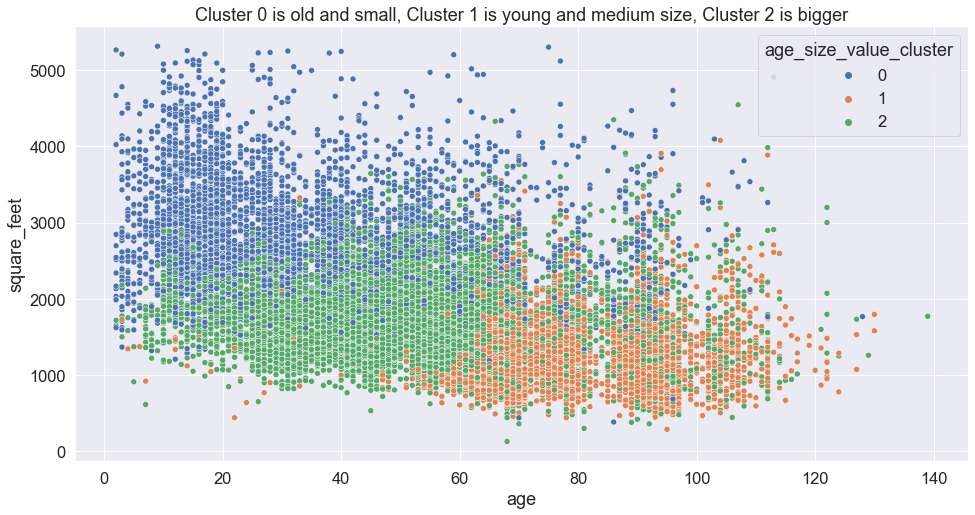

In [22]:
sns.scatterplot(data = train_scaled, x = 'age', y='square_feet', hue='age_size_value_cluster')
plt.title("Cluster 0 is old and small, Cluster 1 is young and medium size, Cluster 2 is bigger")

Text(0.5, 1.0, 'Cluster 0 is old and low value, Cluster 1 is young and low value, Cluster 2 is younger and high value')

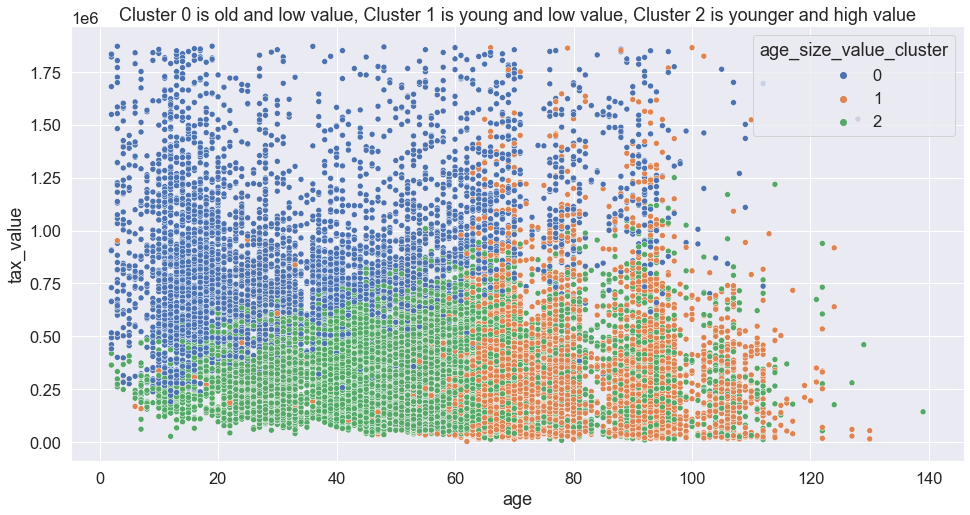

In [23]:
sns.scatterplot(data = train_scaled, x = 'age', y='tax_value', hue='age_size_value_cluster')
plt.title("Cluster 0 is old and low value, Cluster 1 is young and low value, Cluster 2 is younger and high value")

Text(0.5, 1.0, 'Cluster 0 is small and low value, Cluster 1 is bigger and low value, Cluster 2 is bigger and high value')

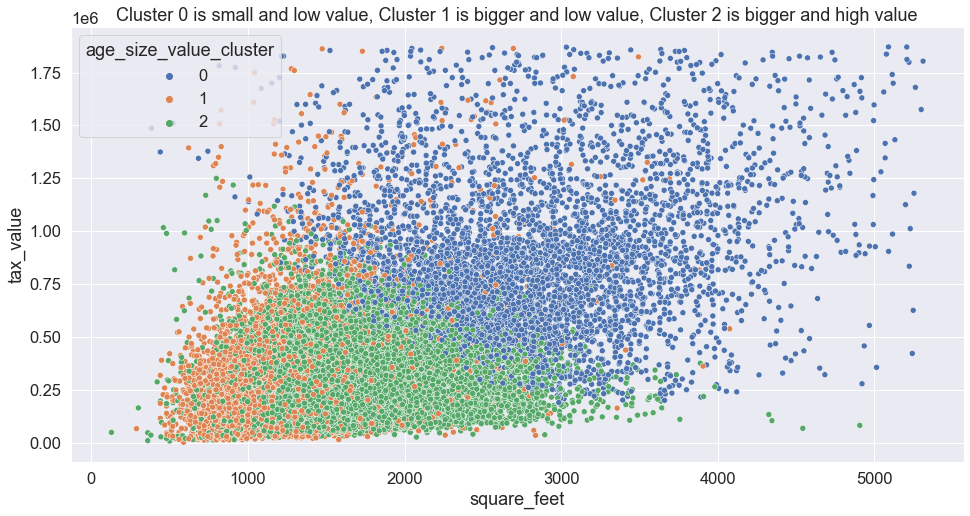

In [24]:
sns.scatterplot(data = train_scaled, x = 'square_feet', y='tax_value', hue='age_size_value_cluster')
plt.title("Cluster 0 is small and low value, Cluster 1 is bigger and low value, Cluster 2 is bigger and high value")

Text(0.5, 1.0, 'Cluster 0 is old and low value, Cluster 1 is young and low value, Cluster 2 is younger and high value')

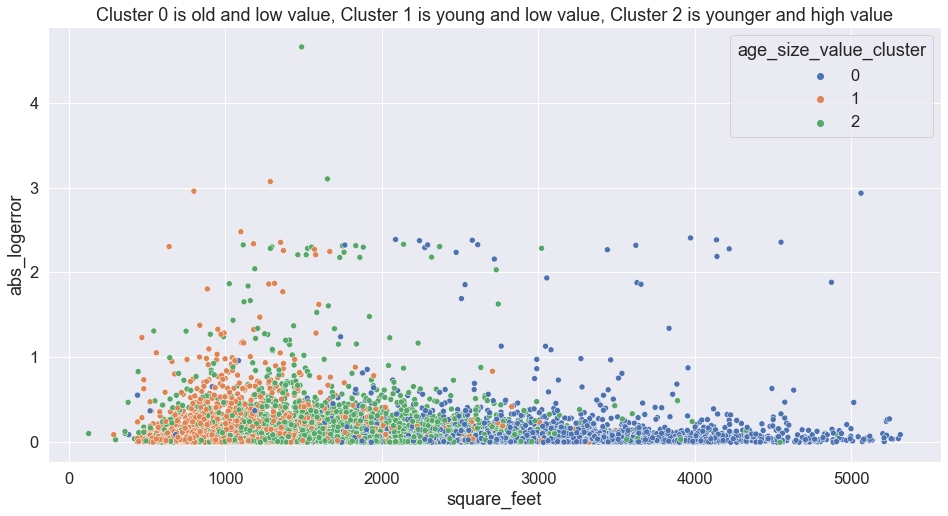

In [25]:
sns.scatterplot(data = train_scaled, x = 'square_feet', y='abs_logerror', hue='age_size_value_cluster')
plt.title("Cluster 0 is old and low value, Cluster 1 is young and low value, Cluster 2 is younger and high value")

In [26]:
train_scaled.groupby('age_size_value_cluster').mean()[['abs_logerror','has_old_heat']]

,abs_logerror,has_old_heat
age_size_value_cluster,,
0,0.066886,0.0
1,0.084062,1.0
2,0.062642,0.0


### cluster structure value per sqft and lot value per sqft

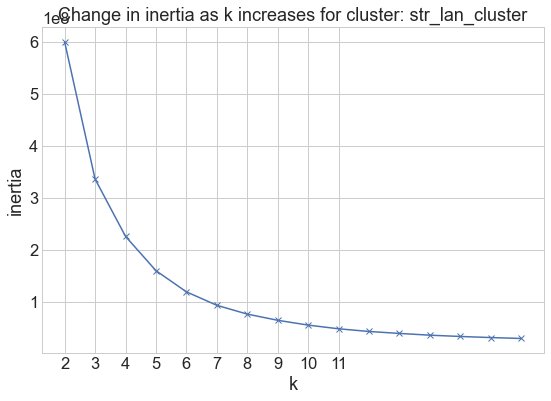

Overall mean logerror: 0.06905191781502365
0 Significant?  True t value:  4.2657667598413065
1 Significant?  True t value:  -4.657866017832623
2 Significant?  True t value:  -3.665302608718916
3 Significant?  True t value:  3.3038628364846567
4 Significant?  True t value:  3.5823788517299797


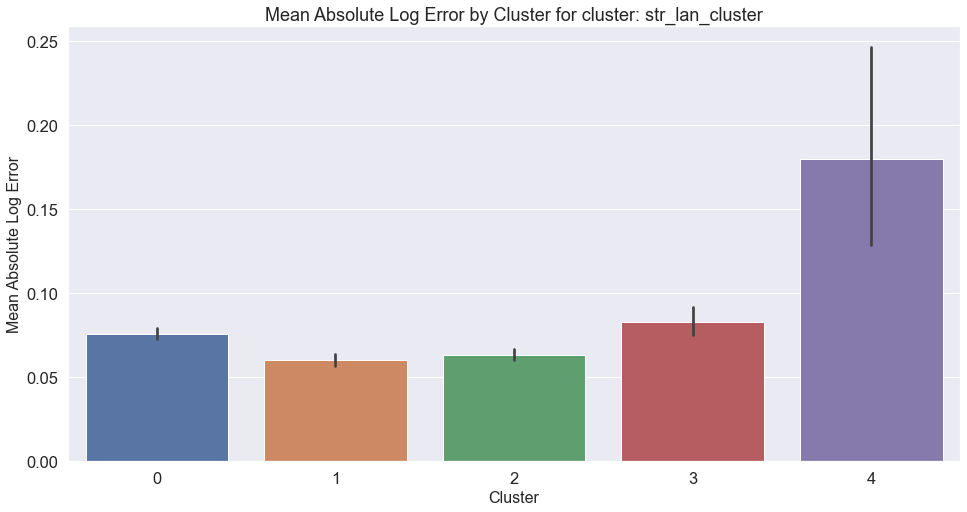

In [27]:
train_scaled = model.perform_cluster_analysis(train_scaled,['structure_dollar_per_sqft','land_dollar_per_sqft'], cluster_qty = 5)

### Is log error significantly different for properties in different counties?
- ANOVA and/or T-test

In [86]:
ventura_properties = train[train.county == 'Ventura County'].logerror
la_properties = train[train.county == 'Los Angeles County'].logerror
orange_properties = train[train.county == 'Orange County'].logerror

- $H_0$: log error means are all equal between each county
- $H_a$: means are not equal to each other

In [18]:
alpha = 0.05

In [19]:
ventura_properties.var(), la_properties.var(), orange_properties.var()

(0.02640727357180353, 0.02601732494807998, 0.04287695019874075)

In [20]:
stats.levene(ventura_properties, la_properties, orange_properties)

LeveneResult(statistic=14.350513208349438, pvalue=5.899117144829073e-07)

In [21]:
# Variances are unequal
# Greater than 30 samples, approximately normal distribution

In [22]:
f, p = stats.kruskal(ventura_properties, la_properties, orange_properties)

In [23]:
print("Can reject null hypothesis, there is a difference between the population medians: ", p<alpha)

Can reject null hypothesis, there is a difference between the population medians:  True


Text(0.5, 1.0, 'Median Log Error by County. Red Line Shows Median for all Properties')

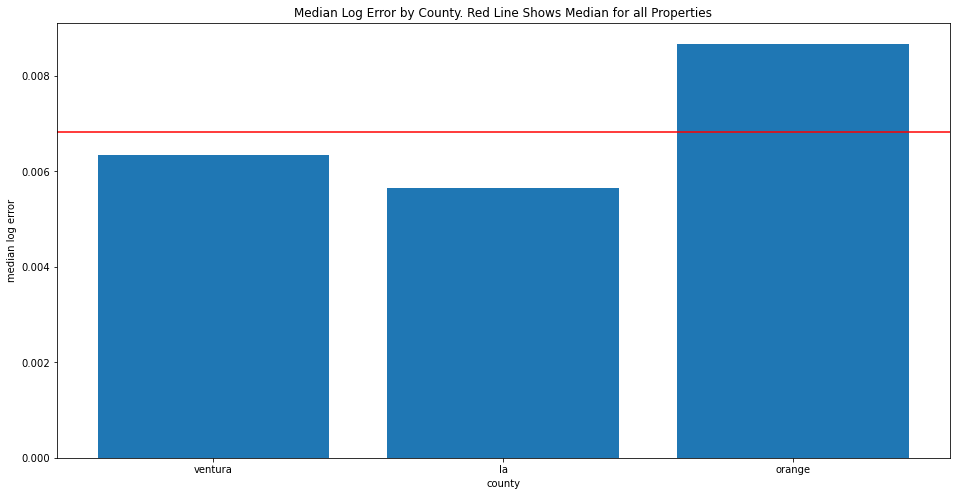

In [24]:
county_data = {'ventura': ventura_properties.median(),
        'la': la_properties.median(),
        'orange': orange_properties.median()}

plt.figure(figsize=(16,8))
plt.bar(county_data.keys(), county_data.values())
plt.xlabel('county')
plt.ylabel('median log error')
plt.axhline(train.logerror.median(),color='r')
plt.title("Median Log Error by County. Red Line Shows Median for all Properties")

### Can conclude that there is a significantly different between the population medians.

In [25]:
t, p = stats.ttest_ind(orange_properties, la_properties, equal_var=False)
print("Orange and LA logerror means differ significantly: ",p<alpha)

Orange and LA logerror means differ significantly:  True


In [26]:
t, p = stats.ttest_ind(orange_properties, ventura_properties, equal_var=False)
print("Orange and Ventura logerror means differ significantly: ",p<alpha)

Orange and Ventura logerror means differ significantly:  True


In [27]:
t, p = stats.ttest_ind(ventura_properties, la_properties, equal_var=False)
print("Ventura and LA logerror means differ significantly: ",p<alpha)

Ventura and LA logerror means differ significantly:  False


### Ventura and LA are fairly close (not significantly different) while Orange is significantly different from the other two counties in terms of mean log error.

In [28]:
county_train = pd.get_dummies(train, columns = ['county'],prefix = 'is')

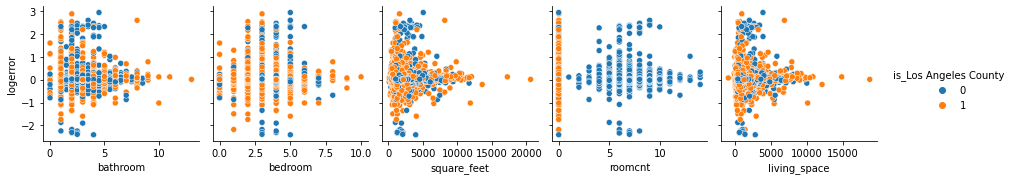

In [29]:
sns.pairplot(x_vars=['bathroom','bedroom','square_feet','roomcnt', 'living_space'], y_vars='logerror', data=county_train, hue='is_Los Angeles County')

## Looking at roomcnt vs logerror  - doesn't look like any data for LA county but for the other counties there appear to be some high and lower clusters of log error

In [30]:
not_la = county_train[county_train["is_Los Angeles County"]==0]

<AxesSubplot:xlabel='roomcnt', ylabel='logerror'>

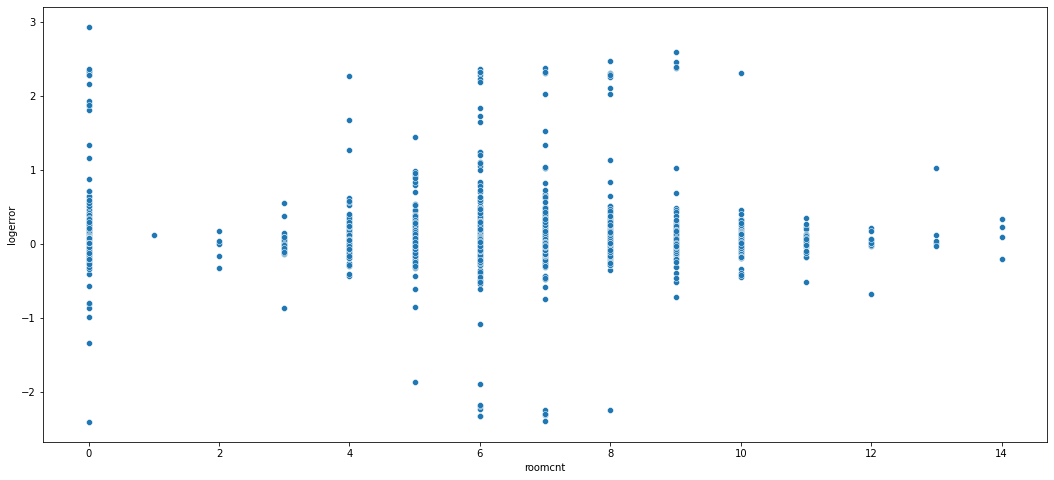

In [31]:
plt.figure(figsize=(18,8))
sns.scatterplot(data = not_la, x='roomcnt', y = 'logerror')

<AxesSubplot:xlabel='roomcnt', ylabel='logerror'>

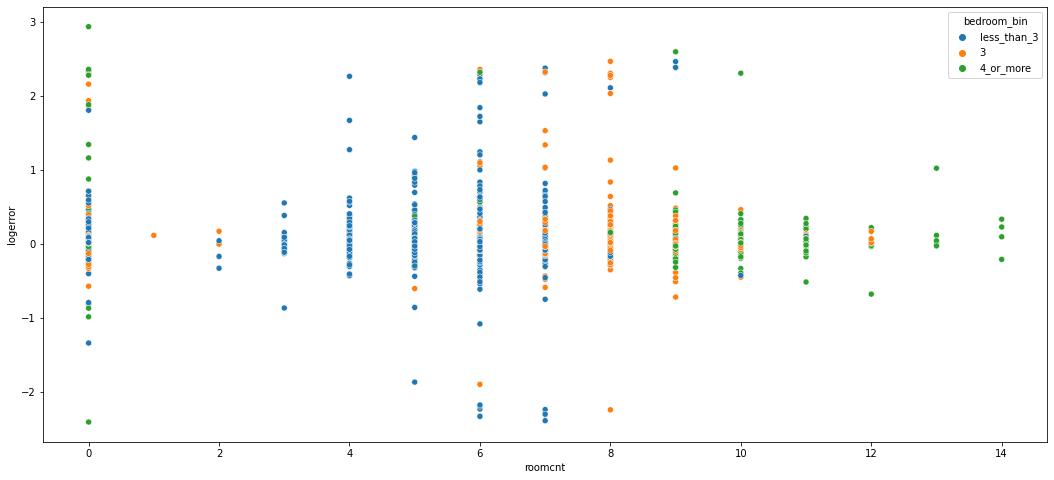

In [32]:
plt.figure(figsize=(18,8))
sns.scatterplot(data = not_la, x='roomcnt', y = 'logerror', hue = 'bedroom_bin')

### Can't find other features to explain the higher and lower clusters of logerror

In [33]:
train.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'age', 'bathroo

## How does log error change with square footage

In [34]:
r, p = stats.pearsonr(train.square_feet, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.03706545213660601 is significant: True
This is a very weak correlation


<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

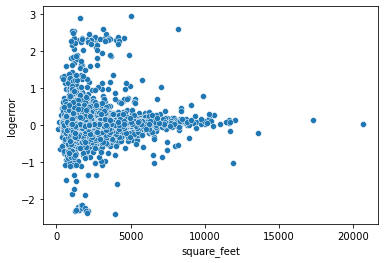

In [35]:
sns.scatterplot(data = train, x = 'square_feet', y = 'logerror')

### Essentially no linear correlation between log error and square footage

In [36]:
# Same with living space
r, p = stats.pearsonr(train.living_space, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.033667425259480355 is significant: True
This is a very weak correlation


### Holding bedroom count constant, how does number of bathrooms correlate with logerror?
- Correlation test

In [37]:
print("Log error to Bathroom count correlation, holding bedroom count constant")
print("------")
for bed in train.bedroom.unique():
    bedroom_sample = train[train.bedroom == bed]
    # Check if actually values in the sample to allow for correlation test
    if len(bedroom_sample)>1:
        r, p = stats.pearsonr(bedroom_sample.bathroom, bedroom_sample.logerror)
        print(f"For {bed} bedrooms, correlation of {r} is significant: {p<alpha}")
        if p<alpha:
            if r<0.3 and r>-0.3:
                print("This is a very weak correlation")

Log error to Bathroom count correlation, holding bedroom count constant
------
For 3.0 bedrooms, correlation of 0.003109047143655637 is significant: False
For 2.0 bedrooms, correlation of -0.01219495122231834 is significant: False
For 4.0 bedrooms, correlation of 0.017800492914307804 is significant: False
For 5.0 bedrooms, correlation of 0.060361772246668416 is significant: True
This is a very weak correlation
For 1.0 bedrooms, correlation of -0.05460323208145078 is significant: False
For 6.0 bedrooms, correlation of 0.05866005673103777 is significant: False
For 7.0 bedrooms, correlation of -0.22176309517539067 is significant: False
For 8.0 bedrooms, correlation of 0.2924469401706446 is significant: False
For 0.0 bedrooms, correlation of -0.1272152908576515 is significant: False
For 9.0 bedrooms, correlation of -0.8528553929073035 is significant: False


<AxesSubplot:xlabel='bathroom', ylabel='logerror'>

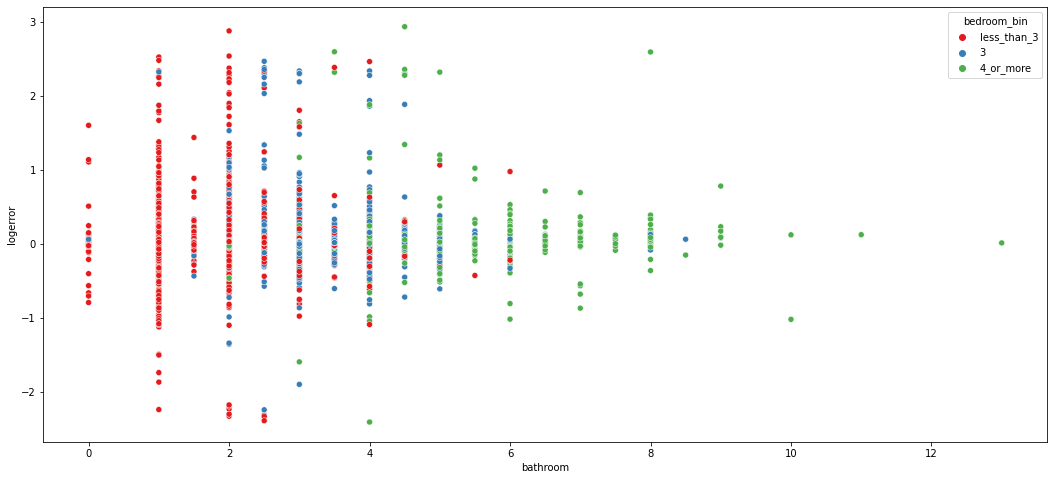

In [38]:
plt.figure(figsize=(18,8))
sns.scatterplot(data = train, hue = 'bedroom_bin', x='bathroom', y='logerror', palette='Set1')

### No correlation between bathroom count and logerror

## What about bedroom count?

In [39]:
r, p = stats.pearsonr(train.bedroom, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.035941868337811586 is significant: True
This is a very weak correlation


Text(0.5, 1.0, 'Median Log Error by Bedroom Count. Red Line Shows Median for all Properties')

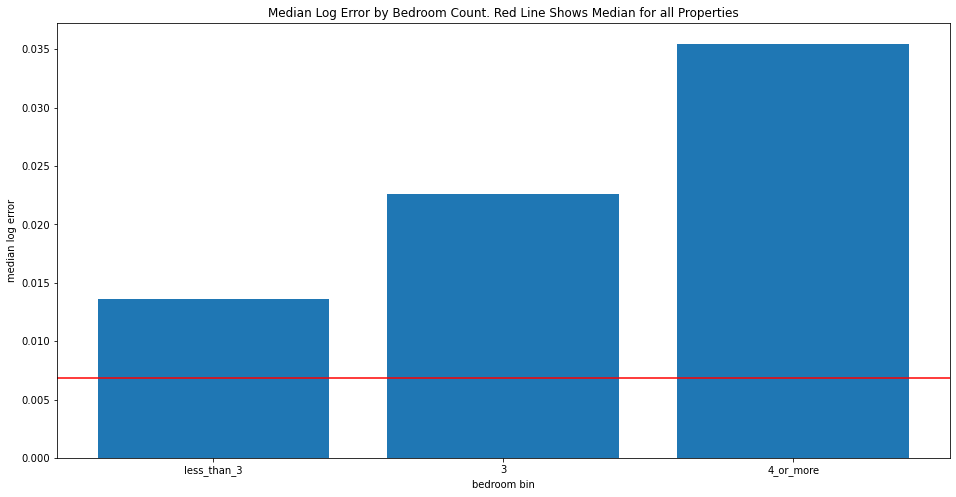

In [40]:
bedroom_data = {k:0 for k in train.bedroom_bin.unique()}
for bed_bin in train.bedroom_bin.unique():
    
    bedroom_data[bed_bin] = train[train.bedroom_bin == bed_bin].logerror.mean()


plt.figure(figsize=(16,8))
plt.bar(bedroom_data.keys(), bedroom_data.values())
plt.xlabel('bedroom bin')
plt.ylabel('median log error')
plt.axhline(train.logerror.median(),color='r')
plt.title("Median Log Error by Bedroom Count. Red Line Shows Median for all Properties")

## Do houses with garages have log errors above or below those without?
    - T-test - will do two sample t-test, 1 tail. Check if with garage has greater error than without garage

In [41]:
with_garage = train[train.has_garage].logerror
without_garage = train[~train.has_garage].logerror

In [42]:
with_garage.var(), without_garage.var()

(0.03739316995581872, 0.02704537746190941)

In [43]:
stats.levene(with_garage, without_garage)

LeveneResult(statistic=38.8499878991891, pvalue=4.6406239350179917e-10)

In [44]:
# Unequal variances


<BarContainer object of 2 artists>

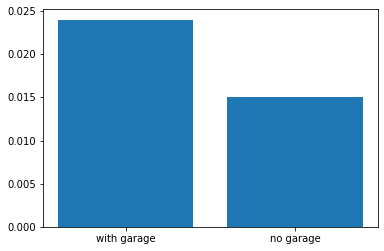

In [45]:
plt.bar(['with garage', 'no garage'],[with_garage.mean(), without_garage.mean()])

In [46]:
t,p = stats.ttest_ind(with_garage, without_garage, equal_var=False)
if (t>0) and (p/2<alpha):
    print("Reject null: mean of logerror for with garage is greater than for those without garage")

Reject null: mean of logerror for with garage is greater than for those without garage


### Does number of garages correlate with higher log error?
- Correlation test

<AxesSubplot:xlabel='garage', ylabel='logerror'>

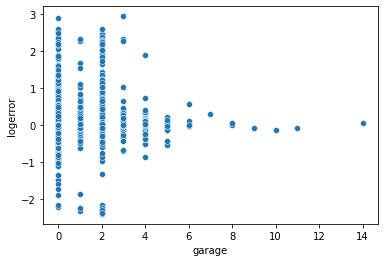

In [47]:
sns.scatterplot(data = train, x = 'garage', y = 'logerror')

In [48]:
r, p = stats.pearsonr(train.square_feet, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.03706545213660601 is significant: True
This is a very weak correlation


### very weak correlation between number of garages and logerror

In [49]:
train.numberofstories.value_counts()

0.0    20501
1.0     4843
2.0     2973
3.0      189
Name: numberofstories, dtype: int64

<AxesSubplot:xlabel='numberofstories', ylabel='logerror'>

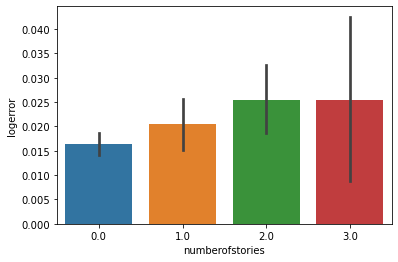

In [50]:
sns.barplot(data = train, x='numberofstories',y='logerror')

### Maybe a small difference depending on number of stories

In [51]:
train.airconditioningdesc.value_counts()

Not Specified    21247
Central           6302
Yes                874
None                73
Wall Unit           10
Name: airconditioningdesc, dtype: int64

<AxesSubplot:xlabel='airconditioningdesc', ylabel='logerror'>

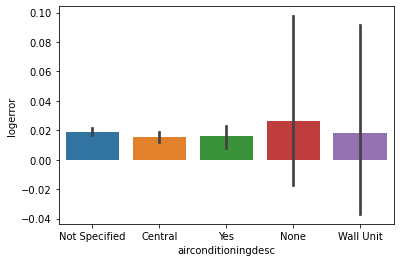

In [52]:
sns.barplot(data = train, x='airconditioningdesc',y='logerror')

### Nothing significant looking for air conditioning

In [53]:
train["age"] = 2017 - train.yearbuilt

<AxesSubplot:xlabel='age', ylabel='logerror'>

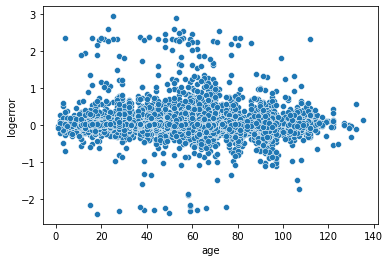

In [54]:
sns.scatterplot(data = train, x='age', y = 'logerror')

### nothing significant looking for age

## regionidcity?

In [55]:
def is_error_above_threshold(regionidcity, threshold):
    return (train.groupby('regionidcity').logerror.agg('mean')>threshold).loc[regionidcity]

In [56]:
train["logerror_above_threshold"]=train.apply(lambda row: is_error_above_threshold(row.regionidcity, 0.1), axis=1)

In [57]:
train[train.logerror_above_threshold].regionidcity.value_counts()

118994.0    39
36502.0     22
25468.0     16
32753.0      6
3491.0       4
13311.0      2
Name: regionidcity, dtype: int64

<AxesSubplot:xlabel='regionidcity', ylabel='logerror'>

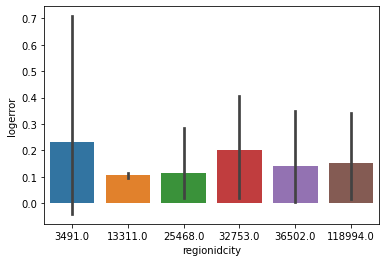

In [58]:
sns.barplot(data = train[train.logerror_above_threshold],  x='regionidcity',y='logerror')

### These 6 regionidcities have greater average logerrors, need to check for significance

In [59]:
regionidcitymeans=[]
ps=[]
num_samples=[]
cities = []
for city in train.regionidcity.unique():
    regionidcitymean = train[train.regionidcity == city].logerror.mean()
    t, p = stats.ttest_1samp(train[train.regionidcity == city].logerror, train.logerror.mean())
    if p<alpha:
        print(city, "City's mean logerror: ",round(regionidcitymean,4), "vs average", 
              round(train.logerror.mean(),4), "Significant?",p<alpha,
             ",number of samples: ",len(train[train.regionidcity == city]))
    regionidcitymeans.append(regionidcitymean)
    ps.append(p)
    num_samples.append(len(train[train.regionidcity == city]))
    cities.append(city)

results = pd.DataFrame(data = {'city':cities,'city_mean':regionidcitymeans, 'p_value':ps, 'number_of_samples':num_samples})
results["significant"]=results.p_value<0.05
results["overall_mean"] = train.logerror.mean()
results["city_vs_overall"] = results.city_mean - results.overall_mean

12447.0 City's mean logerror:  0.0073 vs average 0.0181 Significant? True ,number of samples:  6361
33612.0 City's mean logerror:  -0.0085 vs average 0.0181 Significant? True ,number of samples:  149
46298.0 City's mean logerror:  0.0059 vs average 0.0181 Significant? True ,number of samples:  808
29189.0 City's mean logerror:  -0.0178 vs average 0.0181 Significant? True ,number of samples:  55
10241.0 City's mean logerror:  0.0408 vs average 0.0181 Significant? True ,number of samples:  80
52650.0 City's mean logerror:  0.0421 vs average 0.0181 Significant? True ,number of samples:  414
19177.0 City's mean logerror:  -0.0157 vs average 0.0181 Significant? True ,number of samples:  153
27110.0 City's mean logerror:  0.009 vs average 0.0181 Significant? True ,number of samples:  477
25974.0 City's mean logerror:  0.0092 vs average 0.0181 Significant? True ,number of samples:  139
5465.0 City's mean logerror:  0.0001 vs average 0.0181 Significant? True ,number of samples:  114
26483.0 Ci

In [60]:
# These are the results that are significant. Highest mean city logerror is 0.08
results[results.significant].sort_values('city_mean', ascending=False).head(10)

,city,city_mean,p_value,number_of_samples,significant,overall_mean,city_vs_overall
156,42091.0,0.080233,0.026085,17,True,0.018114,0.062119
168,25621.0,0.075716,0.045891,4,True,0.018114,0.057602
86,26483.0,0.057609,0.006247,124,True,0.018114,0.039495
33,52650.0,0.042143,0.048804,414,True,0.018114,0.024029
25,10241.0,0.040828,0.048283,80,True,0.018114,0.022714
55,25974.0,0.009160,0.019326,139,True,0.018114,-0.008954
43,27110.0,0.008972,0.005105,477,True,0.018114,-0.009142
104,37086.0,0.008400,0.034839,91,True,0.018114,-0.009713
2,12447.0,0.007315,0.000001,6361,True,0.018114,-0.010798
18,46298.0,0.005876,0.010239,808,True,0.018114,-0.012238


## Perhaps these cities are worth putting as their own group (categorical) as they exhibit significant differences from overall mean

In [61]:
train.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'age', 'bathroo

<AxesSubplot:xlabel='age_bin', ylabel='logerror'>

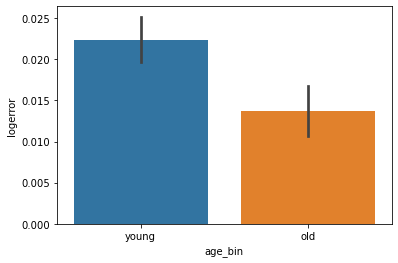

In [62]:
sns.barplot(data = train,  x='age_bin',y='logerror')

## Younger homes exhibit greater logerror

In [63]:
young_homes = train[train.age_bin=='young'].logerror
old_homes = train[train.age_bin=='old'].logerror

In [64]:
stats.levene(young_homes,old_homes)

LeveneResult(statistic=138.73372556932893, pvalue=5.973850727902967e-32)

In [65]:
stats.ttest_ind(young_homes, old_homes, equal_var=False)

Ttest_indResult(statistic=4.196380034519133, pvalue=2.7204573257639104e-05)

Significant difference between young and old homes

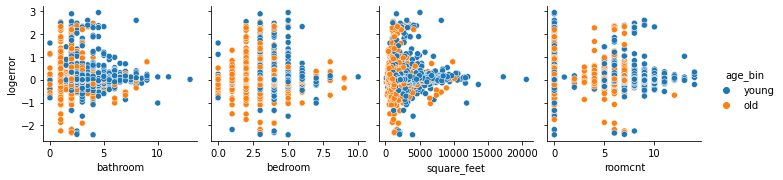

In [66]:
sns.pairplot(x_vars=['bathroom','bedroom','square_feet','roomcnt'], y_vars='logerror', data=train, hue='age_bin')

### Maybe cluster between low and high bathrooms?

In [67]:
train['bathroom_bin'] = pd.qcut(train.bathroom, 2, labels=["less_than_2","2_or_more"])

<AxesSubplot:xlabel='bathroom_bin', ylabel='logerror'>

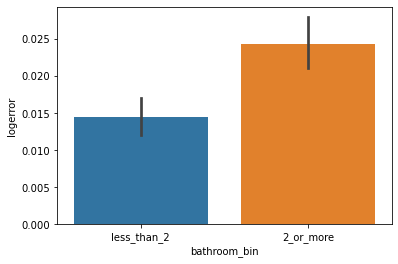

In [68]:
sns.barplot(data = train,  x='bathroom_bin',y='logerror')

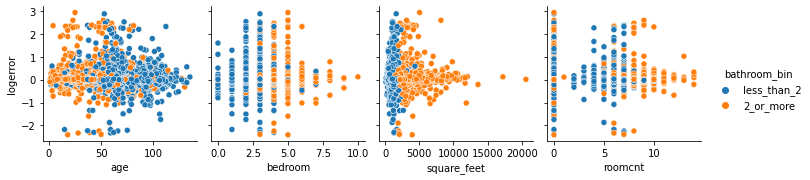

In [69]:
sns.pairplot(x_vars=['age','bedroom','square_feet','roomcnt'], y_vars='logerror', data=train, hue='bathroom_bin')

### Younger homes and 2 or greater bathrooms seem to be one cluster

In [70]:
train.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'age', 'bathroo

### BONUS: Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [71]:
zipmeans=[]
ps=[]
num_samples=[]
for zipcode in train.zip.unique():
    zipmean = train[train.zip == zipcode].logerror.mean()
    t, p = stats.ttest_1samp(train[train.zip == zipcode].logerror, train.logerror.mean())
    # if p<alpha:
    #     print(zipcode, "Zip's mean logerror: ",round(zipmean,4), "vs average", 
    #           round(train.logerror.mean(),4), "Significant?",p<alpha,
    #          ",number of samples: ",len(train[train.zip == zipcode]))
    zipmeans.append(zipmean)
    ps.append(p)
    num_samples.append(len(train[train.zip == zipcode]))

results = pd.DataFrame(data = {'zip_mean':zipmeans, 'p_value':ps, 'number_of_samples':num_samples})
results["significant"]=results.p_value<0.05
results["overall_mean"] = train.logerror.mean()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [72]:
results.head()

,zip_mean,p_value,number_of_samples,significant,overall_mean
0,-0.004726,0.249090,143,False,0.018114
1,0.022269,0.634388,264,False,0.018114
2,0.002773,0.405280,57,False,0.018114
3,-0.031005,0.086056,55,False,0.018114
4,-0.009468,0.063303,76,False,0.018114


# Clustering

In [73]:
train.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'age', 'bathroo

In [74]:
train, _ , _ = wrangle_zillow.scale_data(train, validate, test, features_to_scale=['latitude','condition','longitude','bedroom','bathroom','square_feet','lot_size','structuretaxvaluedollarcnt','age','roomcnt','land_dollar_per_sqft','bed_bath_ratio','structure_dollar_per_sqft','tax_value'])

In [75]:
X = train[['bedroom_scaled','bathroom_scaled','square_feet_scaled']]

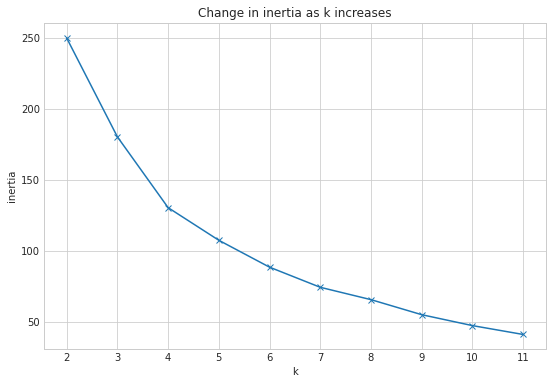

In [76]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## Choose k = 4

In [77]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [78]:
train['cluster'] = kmeans.predict(X)

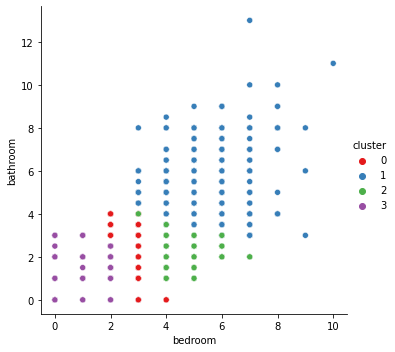

In [79]:
sns.relplot(data = train, x = 'bedroom', y='bathroom', hue='cluster', palette='Set1')

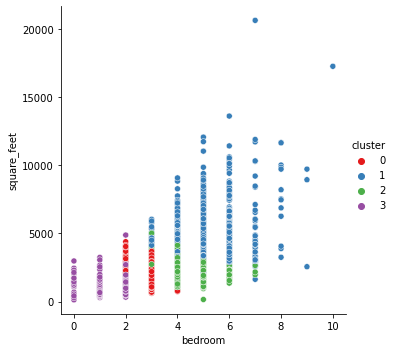

In [80]:
sns.relplot(data = train, x = 'bedroom', y='square_feet', hue='cluster', palette='Set1')

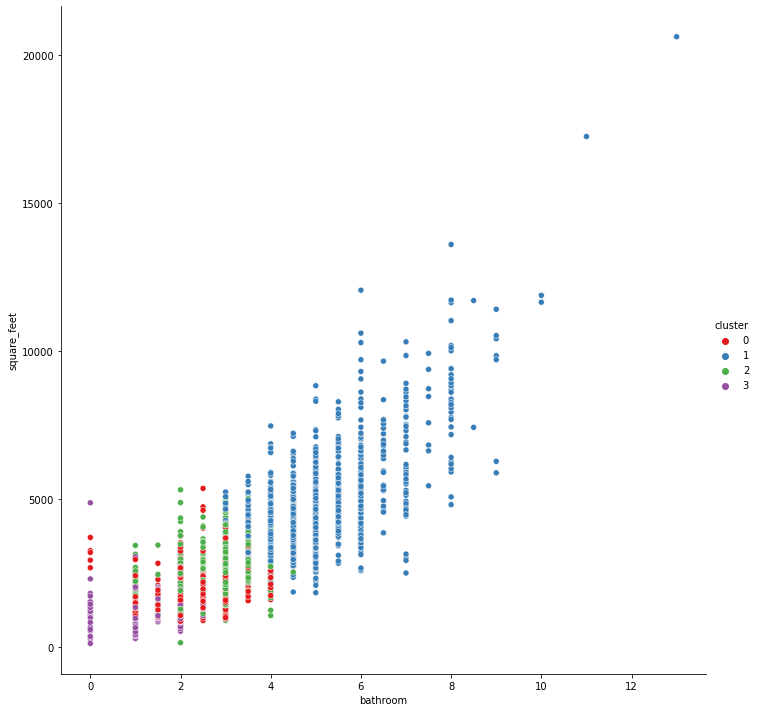

In [81]:
sns.relplot(data = train, x = 'bathroom', y='square_feet', hue='cluster', palette='Set1', height = 10)

In [82]:
bed_bath_sq = train.groupby('cluster').mean()[['bathroom','bedroom','square_feet']]

In [83]:
bed_bath_sq

,bathroom,bedroom,square_feet
cluster,,,
0,2.037194,2.990525,1607.974787
1,4.633141,4.769606,4167.313248
2,2.574420,4.124380,2190.216453
3,1.339015,1.920599,1136.083974


## Four clusters:
- Very high sq ft with both high bed and bath
- High sq ft with high bed and medium bath
- Mid sq ft with med bed and med bath
- Low sq ft with low bed and low bath

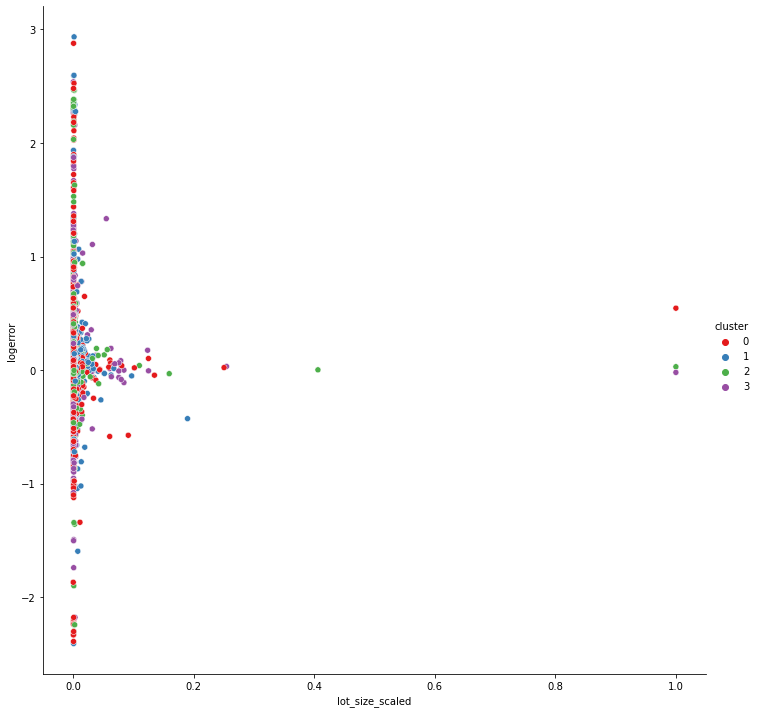

In [84]:
sns.relplot(data = train[train.lot_size_scaled>0], x = 'lot_size_scaled', y='logerror', hue='cluster', palette='Set1', height =10)

### Not much to see with the clusters here for lot size
- Lots of values at 0 or so
- Maybe try a different scaling technique

In [85]:
train.columns[train.columns.str.contains("scale")]

Index(['latitude_scaled', 'condition_scaled', 'longitude_scaled',
       'bedroom_scaled', 'bathroom_scaled', 'square_feet_scaled',
       'lot_size_scaled', 'structuretaxvaluedollarcnt_scaled', 'age_scaled',
       'roomcnt_scaled', 'land_dollar_per_sqft_scaled',
       'bed_bath_ratio_scaled', 'structure_dollar_per_sqft_scaled',
       'tax_value_scaled'],
      dtype='object')

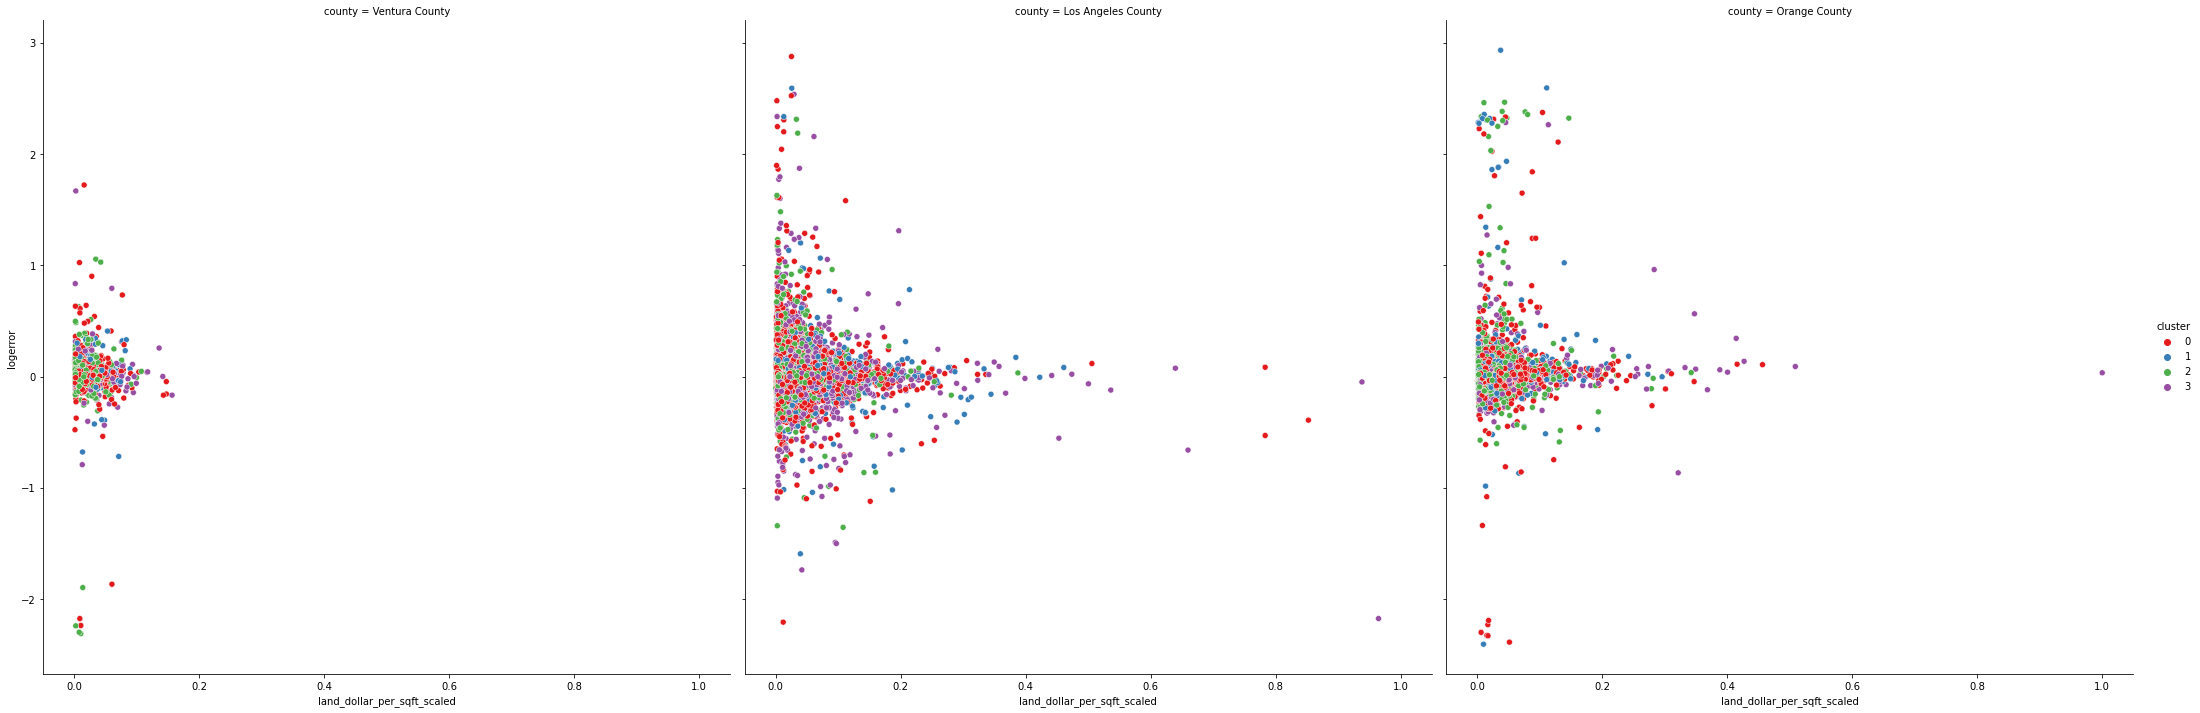

In [86]:
sns.relplot(data = train, x = 'land_dollar_per_sqft_scaled', y='logerror', hue='cluster', palette='Set1', col='county', height =10)

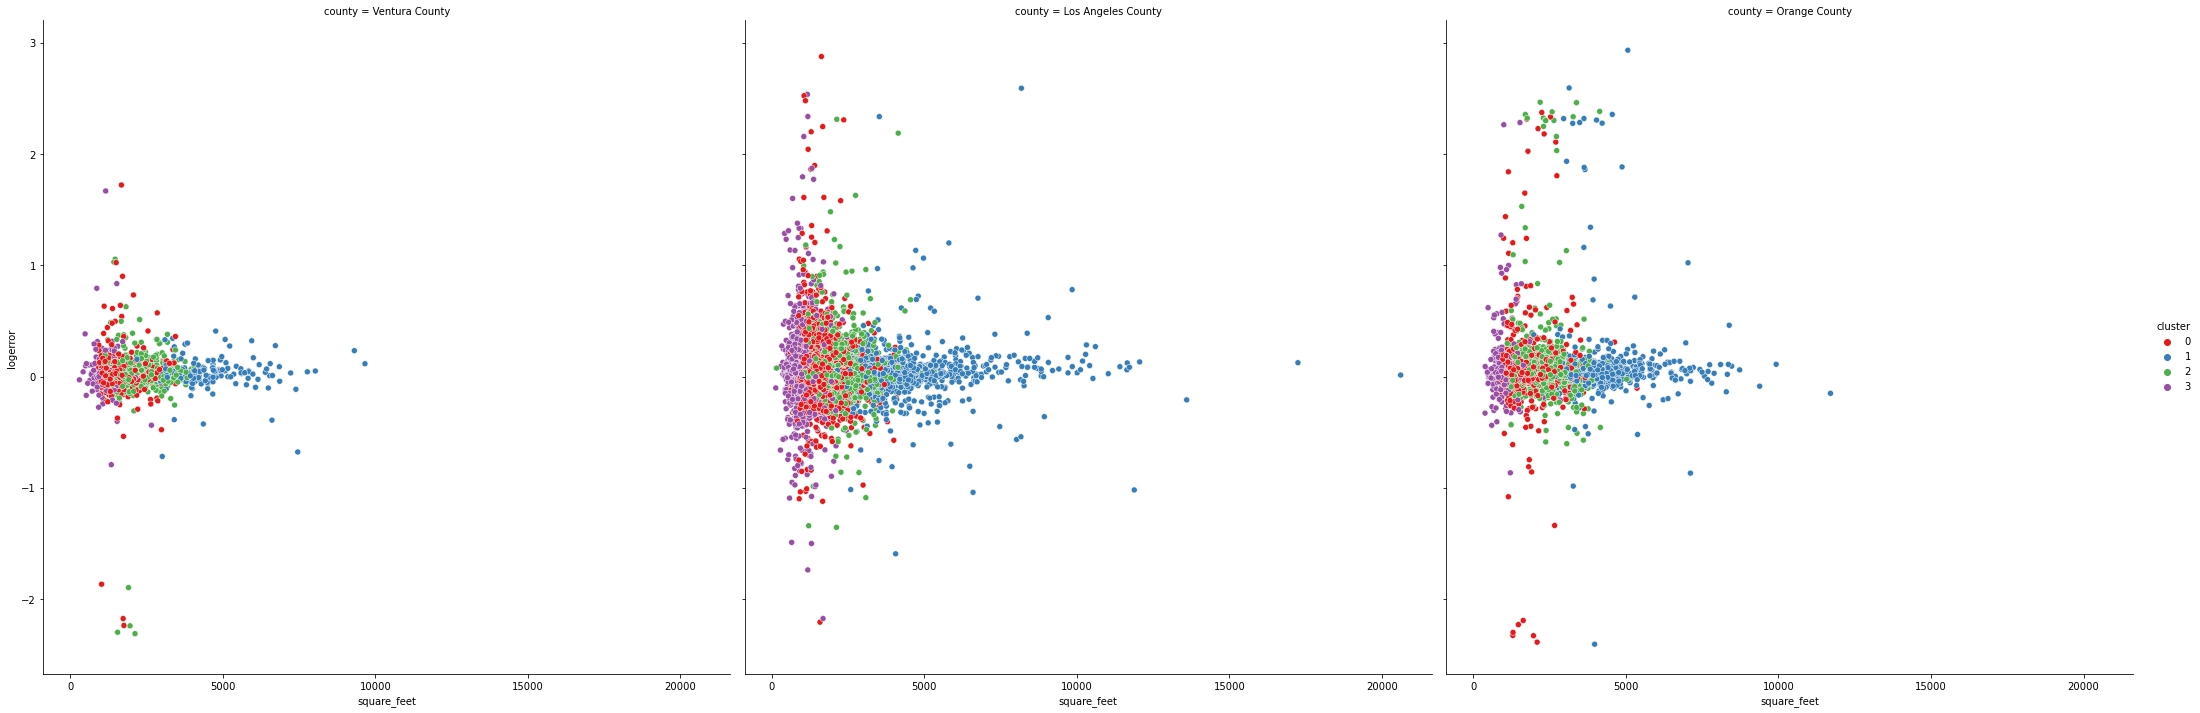

In [87]:
sns.relplot(data = train, x = 'square_feet', y='logerror', hue='cluster', palette='Set1', col='county', height =10)

In [88]:
train.groupby('cluster').mean()[['logerror','bathroom_scaled','bedroom_scaled','square_feet_scaled']]

,logerror,bathroom_scaled,bedroom_scaled,square_feet_scaled
cluster,,,,
0,0.013394,0.156707,0.299053,0.072250
1,0.039677,0.356395,0.476961,0.197194
2,0.022268,0.198032,0.412438,0.100674
3,0.013041,0.103001,0.192060,0.049213


## Performing Anova/Kruskal tests to check if significant difference in log error among these groups
- $H_0$ : no difference in sample means
- $H_a$ : there is a significant difference in sample means between clusters

In [89]:
stats.levene(train[train.cluster == 0].logerror,train[train.cluster == 1].logerror,train[train.cluster == 2].logerror,train[train.cluster == 3].logerror)

LeveneResult(statistic=65.15111917600755, pvalue=5.6350668551971876e-42)

In [90]:
stats.f_oneway(train[train.cluster == 0].logerror,train[train.cluster == 1].logerror,train[train.cluster == 2].logerror,train[train.cluster == 3].logerror)

F_onewayResult(statistic=17.527969684760045, pvalue=2.3018759232681107e-11)

In [91]:
stats.kruskal(train[train.cluster == 0].logerror,train[train.cluster == 1].logerror,train[train.cluster == 2].logerror,train[train.cluster == 3].logerror)

KruskalResult(statistic=189.30286456202987, pvalue=8.633764152639742e-41)

### Reject null - does appear to be a significant difference in means

In [92]:
train.groupby('cluster').mean()

,id,parcelid,basementsqft,bathroom,bedroom,condition,square_feet,fips,fireplacecnt,fullbathcnt,...,bathroom_scaled,square_feet_scaled,lot_size_scaled,structuretaxvaluedollarcnt_scaled,age_scaled,roomcnt_scaled,land_dollar_per_sqft_scaled,bed_bath_ratio_scaled,structure_dollar_per_sqft_scaled,tax_value_scaled
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.501468e+06,1.286091e+07,0.475296,2.037194,2.990525,3.767990,1607.974787,6048.036254,0.138125,1.980894,...,0.156707,0.072250,0.001331,0.015379,0.407174,0.122381,0.032183,0.328388,0.041302,0.016870
1,1.478005e+06,1.305727e+07,3.556048,4.633141,4.769606,4.424014,4167.313248,6051.290651,0.268941,4.476296,...,0.356395,0.197194,0.003062,0.073218,0.252154,0.122033,0.041821,0.213754,0.060504,0.066937
2,1.483952e+06,1.332026e+07,0.167878,2.574420,4.124380,3.286143,2190.216453,6053.364832,0.248298,2.495327,...,0.198032,0.100674,0.001554,0.022006,0.342951,0.203044,0.026630,0.338480,0.037220,0.020800
3,1.479030e+06,1.252473e+07,0.629183,1.339015,1.920599,3.707961,1136.083974,6043.898358,0.060279,1.316358,...,0.103001,0.049213,0.001519,0.010213,0.530642,0.064480,0.043538,0.316805,0.050636,0.013930


Text(0.5, 1.0, 'Mean Logerror by Cluster')

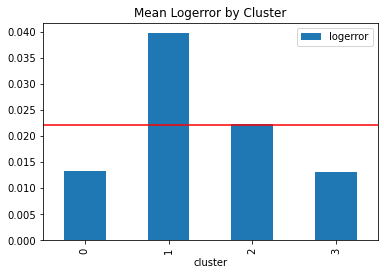

In [93]:
train.groupby('cluster').mean()[['logerror']].plot.bar()
plt.axhline(train.groupby('cluster').mean()['logerror'].mean(), color = 'r')
plt.title("Mean Logerror by Cluster")

In [94]:
train.groupby('cluster').mean()[['logerror','bathroom_scaled','bedroom_scaled','square_feet_scaled']]

,logerror,bathroom_scaled,bedroom_scaled,square_feet_scaled
cluster,,,,
0,0.013394,0.156707,0.299053,0.072250
1,0.039677,0.356395,0.476961,0.197194
2,0.022268,0.198032,0.412438,0.100674
3,0.013041,0.103001,0.192060,0.049213


### Cluster 1 has particularly high average log error relative:
- Cluster 1 is the high bed, high bath, high square feet - mansion
- Cluster 2 also high: this is the next highest (not mansion but pretty big)


## PRICE CLUSTER

In [95]:
cluster_vars = ['structure_dollar_per_sqft_scaled','land_dollar_per_sqft_scaled','tax_rate']

In [96]:
X_train = train
k_range = range(2,20)

In [97]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df


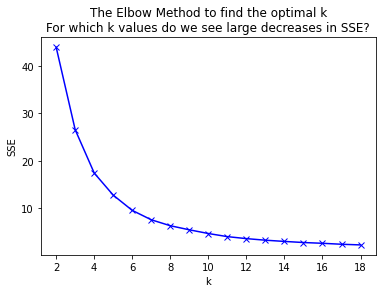

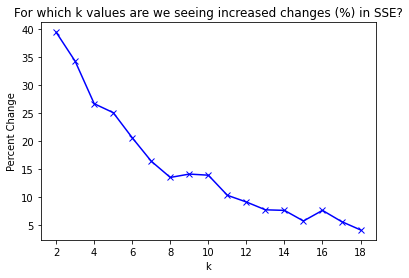

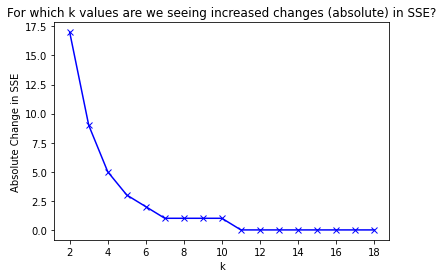

,k,sse,delta,pct_delta
0,2,43.936736,17.0,39.5
1,3,26.570805,9.0,34.3
2,4,17.453111,5.0,26.7
3,5,12.795786,3.0,25.1
4,6,9.589498,2.0,20.6
5,7,7.613286,1.0,16.4
6,8,6.361884,1.0,13.5
7,9,5.501955,1.0,14.1
8,10,4.723492,1.0,13.9
9,11,4.066789,0.0,10.3


In [98]:
find_k(X_train, cluster_vars, k_range)

Will choose k  = 4

In [99]:
X=train[cluster_vars]

In [100]:
k=8
cluster_name = 'price_value_cluster'

# fit kmeans 
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

# get centroid values per variable per cluster
train[cluster_name] = kmeans.predict(X)



## Explore clusters with respect to the variables used to cluster

In [101]:
cluster_vars

['structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled', 'tax_rate']

Text(0.5, 1.0, 'Structure value vs land value')

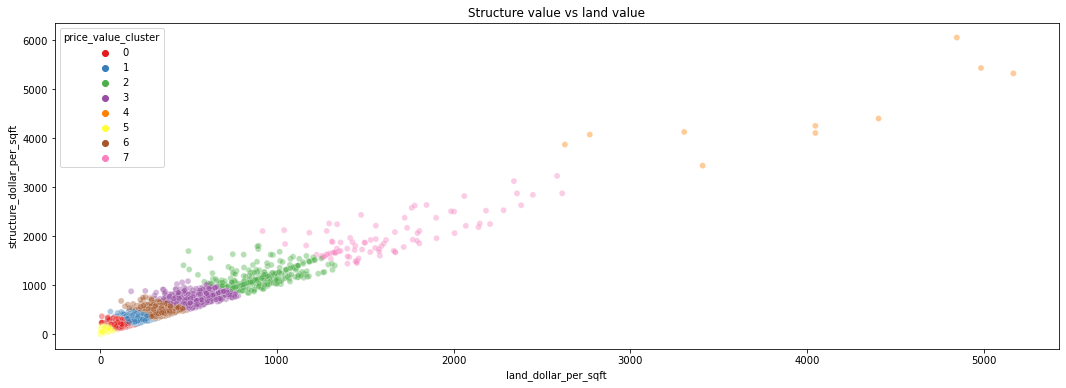

In [102]:
plt.figure(figsize=(18,6))
sns.scatterplot(y=train.structure_dollar_per_sqft, x=train.land_dollar_per_sqft, hue=train.price_value_cluster, palette='Set1',alpha=.4)
plt.title("Structure value vs land value")

Text(0.5, 1.0, 'Tax rate vs Structure Value')

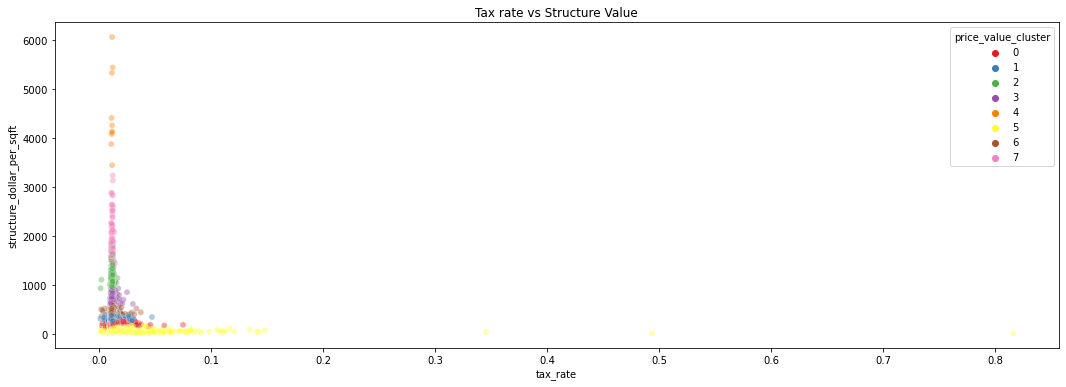

In [103]:
plt.figure(figsize=(18,6))
sns.scatterplot(y=train.structure_dollar_per_sqft, x=train.tax_rate, hue=train.price_value_cluster, palette='Set1',alpha=.4)
plt.title("Tax rate vs Structure Value")


Text(0.5, 1.0, 'Tax rate vs Land Value')

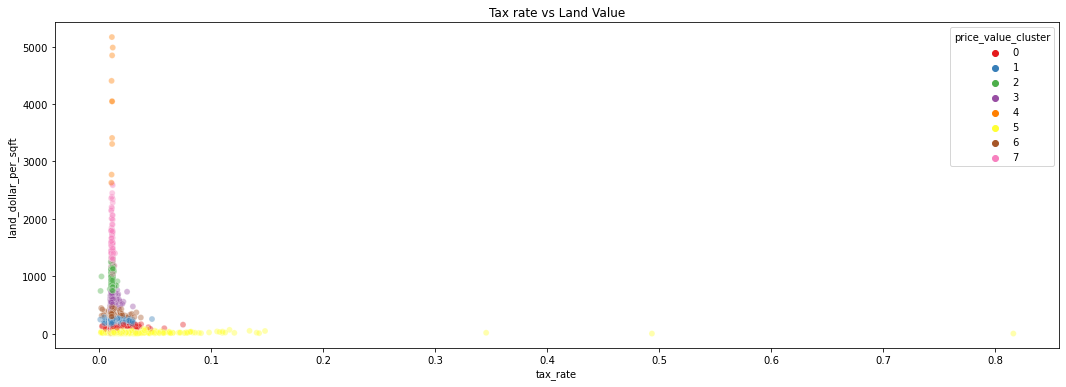

In [104]:
plt.figure(figsize=(18,6))
sns.scatterplot(y=train.land_dollar_per_sqft, x=train.tax_rate, hue=train.price_value_cluster, palette='Set1',alpha=.4)
plt.title("Tax rate vs Land Value")



Not much to say about any of these

## Explore clusters with respect to logerror

Text(0.5, 1.0, 'Log Error vs Tax Rate')

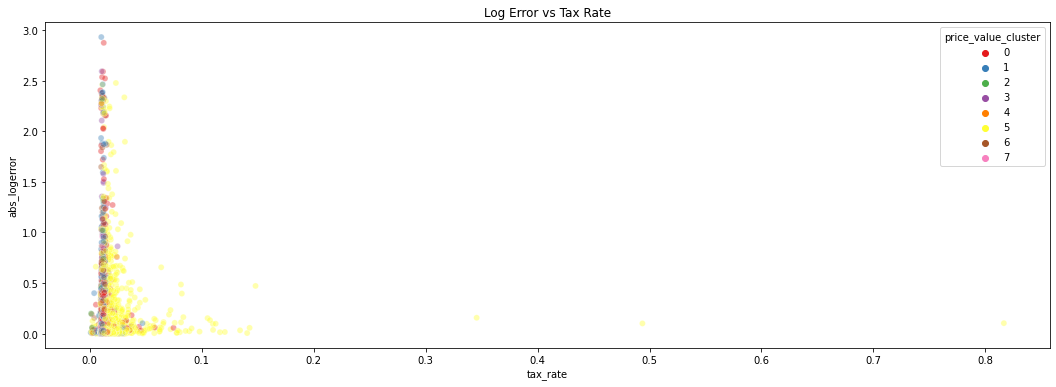

In [117]:
plt.figure(figsize=(18,6))
sns.scatterplot(x=train.tax_rate, y=train.abs_logerror, hue=train.price_value_cluster, palette='Set1',alpha=.4)
plt.title("Log Error vs Tax Rate")

Text(0.5, 1.0, 'Log Error vs Structure Value')

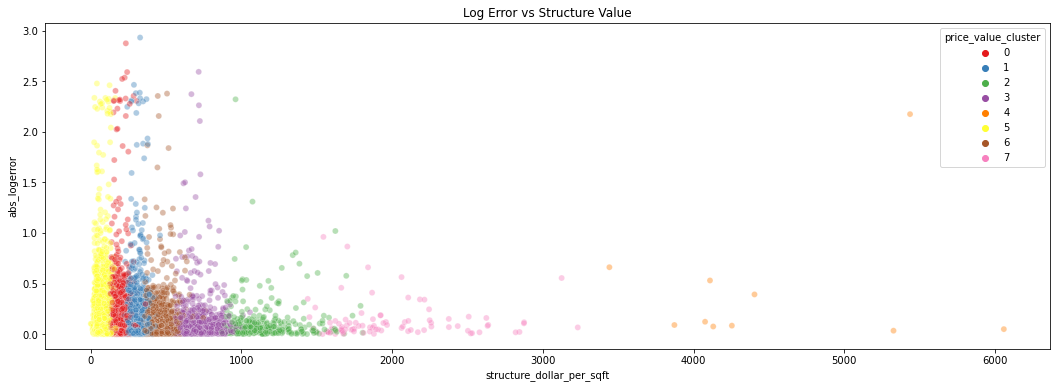

In [118]:
plt.figure(figsize=(18,6))
sns.scatterplot(x=train.structure_dollar_per_sqft, y=train.abs_logerror, hue=train.price_value_cluster, palette='Set1',alpha=.4)
plt.title("Log Error vs Structure Value")

Text(0.5, 1.0, 'Log Error vs Land Value')

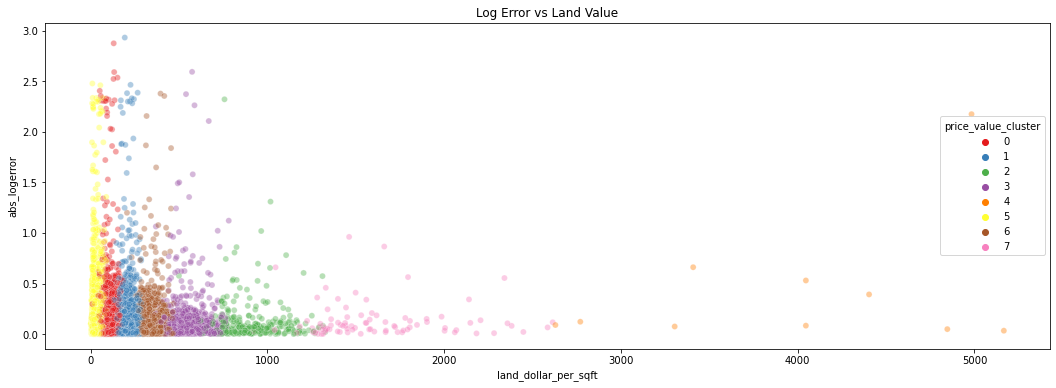

In [119]:
plt.figure(figsize=(18,6))
sns.scatterplot(x=train.land_dollar_per_sqft, y=train.abs_logerror, hue=train.price_value_cluster, palette='Set1',alpha=.4)
plt.title("Log Error vs Land Value")

<AxesSubplot:xlabel='price_value_cluster', ylabel='abs_logerror'>

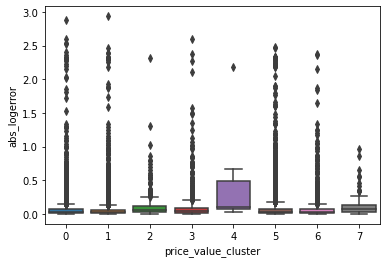

In [116]:
sns.boxplot(data = train, x='price_value_cluster', y = 'abs_logerror')

###  Structure value seemed to indicate cluster 3 potentially has highest logerrors

<AxesSubplot:xlabel='price_value_cluster'>

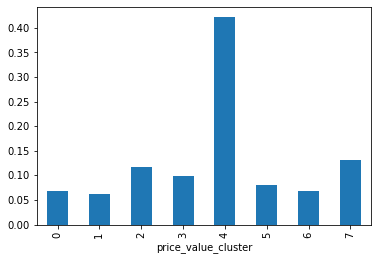

In [120]:
train.groupby('price_value_cluster').mean()['abs_logerror'].plot.bar()

<AxesSubplot:xlabel='price_value_cluster'>

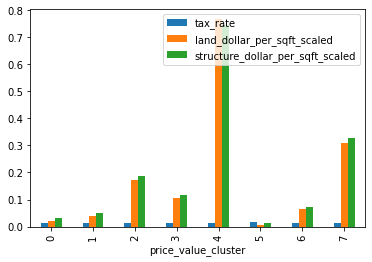

In [110]:
train.groupby('price_value_cluster').mean()[['tax_rate','land_dollar_per_sqft_scaled','structure_dollar_per_sqft_scaled']].plot.bar()

## What are the clusters?
- don't seem to differ significantly except for cluster 2 which is much lower in structure and land value but higher tax rate

<AxesSubplot:xlabel='price_value_cluster'>

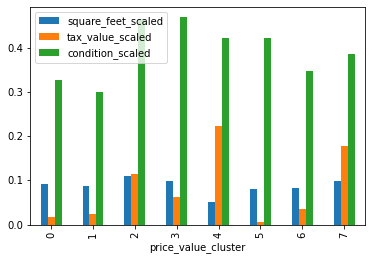

In [111]:
train.groupby('price_value_cluster').mean()[['square_feet_scaled','tax_value_scaled','condition_scaled']].plot.bar()

## Clustering by location

In [112]:
train.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'age', 'bathroo

In [113]:
cluster_vars = ['latitude_scaled','longitude_scaled','age_scaled']

In [114]:
X=train[cluster_vars]

In [115]:
X

,latitude_scaled,longitude_scaled,age_scaled
2777,0.609257,0.245170,0.111940
182,0.833276,0.731528,0.350746
15290,0.387541,0.624441,0.410448
10595,0.524430,0.700460,0.701493
57854,0.364211,0.579316,0.514925
...,...,...,...
37495,0.605667,0.223184,0.380597
20839,0.250091,0.752873,0.052239
24861,0.339005,0.767721,0.455224
35086,0.618369,0.475643,0.298507
